In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import geopandas as gpd #library to read geojson file

import seaborn as sns
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import math

print('Libraries imported.')

Libraries imported.


In [2]:
#pip install git+https://github.com/python-visualization/branca.git@master

## Introduction

Telecommuting appeared in the 1970s and has been strengthen by the information and communication technologies development. 
Today, an employee can work from home as if he were at work. The advantages of teleworking are multiples for both employees and companies, in example, you could significantly reduce your offices rental costs if all of your employees worked from home half of the time. We can also imagine a company without any office and only telecommuter. On the other side, for the employees, working from home is a life-changer, because you don’t have to spend 1hrs per days (or more) in the public transports, it also provides them more flexibility and autonomy so it improves their productivity. 

With the recent lockdown imposed by the COVID crisis, compagnies developed the teleworking to continue their activities, and not only the bigger ones but also the smallest !
Thus, more and more people are teleworking now, but few meetings cannot handle remotely or in the staff’s lounge ! That is why the co-working places are the alternative to oversized premises.

But where should we implant our new co-working office ? That’s the question we will try to answer.


## I- Business Case

We are a real estate company which want to surf on the teleworking wave and find a new location to open co-working office. We have to knowledge to build the best workplaces to allow our clients employees to work efficiently.

We want to open our first co-working office in Paris because with the recent Brexit a lot of financial companies are planning to move there, but there isn’t enough business premises available.

For us, the office must be in Paris intra-muros. For information, Paris is divided in 20 arrondissement which are divided in 80 boroughs. So, we want a model that can cluster each borough  and is also able to predict at which cluster a GPS Coordinates belongs to.
In addition, to define where is the best boroughs to settle our first office we have done a survey of our customers’ employees preferred features :

    1)	It must be easy to reach by public transport ( RER/METRO/TRAM/ Vélib)

    2)	They like to spend their break doing sport or doing shopping

    3)	They want to have a lot of restaurant choice

    4)	It must be easy to book a hostel near the office 


## II- Data

### 1. Paris' Neighborhoods
Paris is divided in 20 Arrondissements and each arrondissements is divided in 4 neighborhood. In order to get a more precise model we decided to work on the 80 neighborhood instead of the 20 arrondissements. 
We can find the datas on the town of paris website : https://parisdata.opendatasoft.com/explore/dataset/quartier_paris/information/

### 2. Public Transport in Paris
We choose to focus on the fastest and easiest way of mobility in Paris : Metro, RER, tramway, navette(mostly airport). This dataset  provided by the RATP give us all of the Paris Metro/RER/Train/Tramway stations. Please note that a station could be used by multiple Metro Lines and RER stations in the same time, a same place will be mentionned as many time as a Metro Line is operating there. 

We won't clean the dupplicated datas because it adds mobility in our criterias.

https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/information/?location=14,48.85351,2.3991&basemap=jawg.streets

### 3. Velib Station in Paris
'Vélib' is a public sharing bicycle service. Added to a great public transport service (RER/Metro), Vélib is a great way to do the last kilometers.

The data is provided by the Town of Paris website : https://parisdata.opendatasoft.com/explore/dataset/velib-emplacement-des-stations/information/

### 4. Sportive equipments
Because the opportunity to do sport during our break is a real advantage to boost the teams, we added their location to our model. 

The data is provided by the French Government on : https://www.data.gouv.fr/fr/datasets/recensement-des-equipements-sportifs-espaces-et-sites-de-pratiques-2/
In this DataSet we have got all of the sportives equipments in France ordered by department / usage / user.

Only few datas interest us : 
- DepCode : Department code (Paris intra-muros is 75)
- Utilisateurs : Filtered on : 'Individuel(s) / Famille(s)' ( Only the free-access equipment interest us)
- InsNom : Equipment name

Note : We will clean the dupplicated datas because we just want to know how many Sportive Centers there is in the neighborough and not each sportive associations and activities.

### 5. Population of Paris per Neighborhood
This data represents the population of paris per neighborhood (in 1999). I didn't find a more recent dataset, however since 1999 the Paris population increased by 3.74% (from 2 125 246 to 2 206 488.) 
https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris

### 6. Foursquare informations
We will use the foursquare database to get some informations on each borough depending on the GPS coordinates and a radius.
- NB of Hostel
- NB of Restaurant
- Store / Services

### 7. Functions we will use

In [3]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from math import radians, cos, sin, asin, sqrt, pi
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def radius_quartier(surface):
    """
    Transform an area to a radius
    """
    radius = sqrt((surface/math.pi))
    return radius

def nb_dist_to_arrond(lat_arr,long_arr,lat_sport_serie,long_sport_serie,dist_max):
    """
    Get the distance between two object with the GPS coordinates.
    """
    c=0
    for i in range(len(df_equip_sportif_paris['Latitude'])):
        d = haversine(lat_arr,long_arr,lat_sport_serie[i],long_sport_serie[i])
        if d < dist_max:
            c=c+1
        else:
            c=c
    return c
    


def is_in_polygon(long,lat,polygon):
    """
    Return true/false if in or not in Polygon
    """
    point = Point(long,lat)
    polygon = Polygon(polygon)
    return polygon.contains(point)


def which_nbh(long_install,lat_install, df_NBH):
    """
    Return the NBH_Num of a long/lat gps.
    """
    NBH_polygon = df_NBH['geometry']
    NBH_quartier = df_NBH['NBH_Num']
    long_equip = long_install
    lat_equip = lat_install
    
    for i in range(len(NBH_polygon)):
        if is_in_polygon(long_equip, lat_equip, NBH_polygon[i]) == True:
            return NBH_quartier[i]
        
def remove_whitespace(x):
    try:
        # remove spaces inside and outside of string
        x = "".join(x.split())

    except:
        pass
    return x


## III - Methodologie

## 1. Data cleaning

### 1.1. Paris' Neighborhood

In [4]:
#Extract each neighborhood from geojson 

quartier = gpd.read_file('quartier_paris.geojson')
df_nbh = pd.DataFrame(quartier)
df_nbh.drop(['n_sq_qu','c_quinsee','perimetre','n_sq_ar'],axis=1,inplace=True)
df_nbh.rename(columns={'c_qu': 'NBH_Num', 
                           'l_qu': 'NBH_Name',
                           'c_ar' : 'Arrondissement',
                           'surface' : 'NBH_AREA_m2'}, inplace=True)

In [5]:
#Get every neighborhood center
df_latlong_nbh = pd.read_csv('quartier_paris.csv',sep=';')
new = df_latlong_nbh['Geometry X Y'].str.split(",", n = 1, expand = True)
df_latlong_nbh['NBH_Latitude']=new[0]
df_latlong_nbh['NBH_Longitude']=new[1]
df_latlong_nbh['NBH_Latitude'] = pd.to_numeric(df_latlong_nbh['NBH_Latitude'])
df_latlong_nbh['NBH_Longitude'] = pd.to_numeric(df_latlong_nbh['NBH_Longitude'])
df_latlong_nbh = df_latlong_nbh[['C_QU','NBH_Latitude','NBH_Longitude']]
df_latlong_nbh.rename(columns={'C_QU': 'NBH_Num'}, inplace=True)

In [6]:
#merge the dataframes
df_nbh = pd.merge(df_nbh,df_latlong_nbh, on='NBH_Num',how='inner')
df_nbh.head()

NBH_Num   NBH_AREA_m2                   NBH_Name  Arrondissement  \
0       14  4.220282e+05              Saint-Gervais               4   
1       25  8.265594e+05       Saint-Thomas-d'Aquin               7   
2       38  4.721136e+05          Porte-Saint-Denis              10   
3        1  8.690007e+05  Saint-Germain-l'Auxerrois               1   
4       73  1.285705e+06                   Villette              19   

                                            geometry  NBH_Latitude  \
0  POLYGON ((2.36376 48.85568, 2.36294 48.85456, ...     48.855719   
1  POLYGON ((2.32213 48.84925, 2.32054 48.84842, ...     48.855263   
2  POLYGON ((2.35534 48.87126, 2.35426 48.86933, ...     48.873618   
3  POLYGON ((2.34459 48.85405, 2.34459 48.85405, ...     48.860650   
4  POLYGON ((2.37050 48.87820, 2.37028 48.87799, ...     48.887661   

   NBH_Longitude  
0       2.358162  
1       2.325588  
2       2.352283  
3       2.334910  
4       2.374468

### 1.2 Public Transport - RER/Metro/Tramway

#### 1.2.1 Paris public transport stations Data Frame

In [7]:
df_PT = pd.read_csv('emplacement-des-gares-idf.csv',sep=';')
df_PT = df_PT[['nomlong','mode_','Geo Point']]
#Extraction of Latitude and longitude from 'Geo Point' column
new = df_PT['Geo Point'].str.split(",", n = 1, expand = True)
df_PT['Latitude']=new[0]
df_PT['Longitude']=new[1]
df_PT['Latitude'] = pd.to_numeric(df_PT['Latitude'])
df_PT['Longitude'] = pd.to_numeric(df_PT['Longitude'])
df_PT.drop('Geo Point',axis=1,inplace=True)

In [8]:
# Adding NBH_Num to each row
df_PT_finished = df_PT
a=[]
for i in range(len(df_PT_finished['Latitude'])):
    a.append(which_nbh(df_PT_finished['Longitude'][i],df_PT_finished['Latitude'][i],df_nbh))
NBH_num = pd.Series(a)
df_PT_finished['NBH_Num']=NBH_num

#Cleaning out of paris intra-muros data
print('--- Before cleaning ---')
print('NB rows',df_PT_finished['nomlong'].count())
print('NB NaN rows',df_PT_finished['NBH_Num'].isnull().sum())

df_PT_finished.dropna(axis=0,inplace=True)

print('--- After cleaning ---')
print('NB rows',df_PT_finished['nomlong'].count())
print('NB NaN rows',df_PT_finished['NBH_Num'].isnull().sum())
df_PT_finished.head()

--- Before cleaning ---
NB rows 1149
NB NaN rows 725
--- After cleaning ---
NB rows 424
NB NaN rows 0


nomlong  mode_   Latitude  Longitude  NBH_Num
0             BOTZARIS  Metro  48.879482   2.389116     75.0
1  ASSEMBLEE NATIONALE  Metro  48.860787   2.320998     26.0
2               BALARD  Metro  48.835931   2.278162     60.0
3             BASTILLE  Metro  48.852479   2.369321     48.0
4              BEL-AIR  Metro  48.841338   2.400919     45.0

#### 1.2.1 Paris public transport stations PER BOROUGH Data Frame

In [9]:
# Counting NB of PT station
NB_PT_station = pd.DataFrame(df_PT_finished['NBH_Num'].value_counts())
NB_PT_station.reset_index(inplace=True)
NB_PT_station.rename(columns={'NBH_Num' : 'NB of PT station','index': 'NBH_Num'}, inplace=True)

#Frequency per borough
a = NB_PT_station['NB of PT station'] / NB_PT_station['NB of PT station'].sum()
NB_PT_station['PT_station_frequency'] = a

print(NB_PT_station['NB of PT station'].sum())
NB_PT_station.head()

424


NBH_Num  NB of PT station  PT_station_frequency
0     37.0                14              0.033019
1     46.0                13              0.030660
2     60.0                12              0.028302
3     32.0                12              0.028302
4     75.0                11              0.025943

### 1.3 Velib Stations in Paris

#### 1.3.1 Paris Velib Stations Data Frame

In [10]:
df_velib = pd.read_csv('station_velib.csv',sep=';')

#Extraction of Latitude and longitude from 'Coordonnées géographiques' column
new = df_velib['Coordonnées géographiques'].str.split(",", n = 1, expand = True)
df_velib['Latitude']=new[0]
df_velib['Longitude']=new[1]
df_velib['Latitude'] = pd.to_numeric(df_velib['Latitude'])
df_velib['Longitude'] = pd.to_numeric(df_velib['Longitude'])
df_velib.drop('Coordonnées géographiques',axis=1,inplace=True)

In [11]:
# Adding NBH_Num to each row
df_velib_finished = df_velib
a=[]
for i in range(len(df_velib_finished['Latitude'])):
    a.append(which_nbh(df_velib_finished['Longitude'][i],df_velib_finished['Latitude'][i],df_nbh))
NBH_num = pd.Series(a)
df_velib_finished['NBH_Num']=NBH_num

#Cleaning out of paris intra-muros data
print('--- Before cleaning ---')
print('NB rows',df_velib_finished['Nom de la station'].count())
print('NB NaN rows',df_velib_finished['NBH_Num'].isnull().sum())

df_velib_finished.dropna(axis=0,inplace=True)

print('--- After cleaning ---')
print('NB rows',df_velib_finished['Nom de la station'].count())
print('NB NaN rows',df_velib_finished['NBH_Num'].isnull().sum())

df_velib_finished.reset_index(inplace=True)
df_velib_finished.head()

--- Before cleaning ---
NB rows 1397
NB NaN rows 394
--- After cleaning ---
NB rows 1003
NB NaN rows 0


index  Identifiant station                       Nom de la station  \
0      1                15047                     Morillons - Dantzig   
1      2                17010        Jonquière - Docteur Paul Brousse   
2      3                17032  Jean Oestreicher - Porte de Champerret   
3      4                 8016                        Square Louis XVI   
4      5                18024                  Clignancourt - Ordener   

   Capacité de la station   Latitude  Longitude  NBH_Num  
0                      52  48.833101   2.299380     57.0  
1                      40  48.894800   2.318705     68.0  
2                      21  48.886556   2.288640     65.0  
3                      29  48.873204   2.323659     31.0  
4                      35  48.891458   2.348636     70.0

#### 1.3.2 Paris Velib Stations PER BOROUGH Data Frame

In [12]:
# Counting NB of velib station
NB_velib_station = pd.DataFrame(df_velib_finished['NBH_Num'].value_counts())
NB_velib_station.reset_index(inplace=True)
NB_velib_station.rename(columns={'NBH_Num' : 'NB of velib station','index': 'NBH_Num'}, inplace=True)

#Frequency per borough
a = NB_velib_station['NB of velib station'] / NB_velib_station['NB of velib station'].sum()
NB_velib_station['velib_station_frequency'] = a

print(NB_velib_station['NB of velib station'].sum())
NB_velib_station.head()

1003


NBH_Num  NB of velib station  velib_station_frequency
0     50.0                   32                 0.031904
1     80.0                   30                 0.029910
2     57.0                   27                 0.026919
3     46.0                   27                 0.026919
4     69.0                   23                 0.022931

### 1.4 Sportive equipment in Paris

#### 1.4.1 Sportive equipment Data Frame

In [13]:
df_equip_sportif_paris = pd.read_csv('recensement-des-equipements-sportifs-idf.csv',sep=";")
#Filtering on DepCode == 75 because all of the Paris Intra-muros borough are located in the depcode 75
df_equip_sportif_paris = df_equip_sportif_paris[df_equip_sportif_paris['DepCode']==75]
#Filtering on the columns we need
df_equip_sportif_paris = df_equip_sportif_paris[['InsNom','Utilisateurs','gps']]
# Filtering on Utilisateurs == 'Individuel(s) / Famille(s)' which means only equipments which are in free access.
df_equip_sportif_paris = df_equip_sportif_paris[df_equip_sportif_paris['Utilisateurs'] == 'Individuel(s) / Famille(s)'].drop_duplicates(subset=['InsNom'])
df_equip_sportif_paris.reset_index(inplace=True)
df_equip_sportif_paris.drop('index',axis=1,inplace=True)

#Extraction of Latitude and longitude from 'gps' column
new = df_equip_sportif_paris['gps'].str.split(",", n = 1, expand = True)
df_equip_sportif_paris['Latitude']= new[0]
df_equip_sportif_paris['Longitude'] = new[1]
df_equip_sportif_paris = df_equip_sportif_paris.drop('gps',axis=1)
df_equip_sportif_paris['Latitude'] = pd.to_numeric(df_equip_sportif_paris['Latitude'])
df_equip_sportif_paris['Longitude'] = pd.to_numeric(df_equip_sportif_paris['Longitude'])
print(df_equip_sportif_paris.shape)

(265, 4)


In [14]:
# Adding NBH_Num to each row
df_equip_sportif_paris_finished = df_equip_sportif_paris
a=[]
for i in range(len(df_equip_sportif_paris_finished['Latitude'])):
    a.append(which_nbh(df_equip_sportif_paris_finished['Longitude'][i],df_equip_sportif_paris_finished['Latitude'][i],df_nbh))
NBH_num = pd.Series(a)
df_equip_sportif_paris_finished['NBH_Num']=NBH_num

#Cleaning out of paris intra-muros data
print('--- Before cleaning ---')
print('NB rows',df_equip_sportif_paris_finished['InsNom'].count())
print('NB NaN rows',df_equip_sportif_paris_finished['NBH_Num'].isnull().sum())

df_equip_sportif_paris_finished.dropna(axis=0,inplace=True)

print('--- After cleaning ---')
print('NB rows',df_equip_sportif_paris_finished['InsNom'].count())
print('NB NaN rows',df_equip_sportif_paris_finished['NBH_Num'].isnull().sum())


df_equip_sportif_paris_finished.head()

--- Before cleaning ---
NB rows 265
NB NaN rows 0
--- After cleaning ---
NB rows 265
NB NaN rows 0


InsNom                Utilisateurs  Latitude  \
0               Institut Ludong Ming  Individuel(s) / Famille(s)  48.86421   
1            Espace Sportif Pontoise  Individuel(s) / Famille(s)  48.84911   
2   Cmg Sports Club One Montparnasse  Individuel(s) / Famille(s)  48.84551   
3        Caisse des Depots - U.S.A.C  Individuel(s) / Famille(s)  48.85953   
4  Les Thermes - Hotel Royal Monceau  Individuel(s) / Famille(s)  48.87590   

   Longitude  NBH_Num  
0    2.34405        2  
1    2.35181       17  
2    2.32574       23  
3    2.32643       25  
4    2.30022       30

#### 1.4.2 Sportive equipment PER BOROUGH Data Frame

In [15]:
# NB of sportive equipment
NB_sportive_equipment = pd.DataFrame(df_equip_sportif_paris_finished['NBH_Num'].value_counts())
NB_sportive_equipment.reset_index(inplace=True)
NB_sportive_equipment.rename(columns={'NBH_Num' : 'NB of sportive equipment','index': 'NBH_Num'}, inplace=True)

#Frequency per borough
a = NB_sportive_equipment['NB of sportive equipment'] / NB_sportive_equipment['NB of sportive equipment'].sum()
NB_sportive_equipment['sportive_equipment_frequency'] = a

print(NB_sportive_equipment['NB of sportive equipment'].sum())
NB_sportive_equipment.head()

265


NBH_Num  NB of sportive equipment  sportive_equipment_frequency
0       43                        13                      0.049057
1       50                        13                      0.049057
2       56                        11                      0.041509
3       80                        10                      0.037736
4       59                         9                      0.033962

### 1.5 Population of Paris per borough

In [16]:
#Exteracting from wikipedia
df_paris_pop = pd.read_html('https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris')
df_paris_pop = df_paris_pop[0]

list=[]
for i in range(1,81):
    list.append(i)
df_paris_pop['Quartiers']=list
df_paris_pop = df_paris_pop[['Quartiers','Quartiers.1','Population en1999 (hab.)[2]']]
df_paris_pop.rename(columns={'Quartiers': 'NBH_Num',
                          'Quartiers.1': 'NBH_Name',
                          'Population en1999 (hab.)[2]' : 'Population_in_1999'},inplace=True)
df_paris_pop['Population_in_1999']=df_paris_pop['Population_in_1999'].apply(remove_whitespace)
df_paris_pop['Population_in_1999'] = pd.to_numeric(df_paris_pop['Population_in_1999'])

a = df_paris_pop['Population_in_1999'] / df_paris_pop['Population_in_1999'].sum()
df_paris_pop['Population_frequency'] = a

print('Total Paris population in 1999 : ',df_paris_pop['Population_in_1999'].sum())
df_paris_pop.head()

Total Paris population in 1999 :  2125851


NBH_Num                   NBH_Name  Population_in_1999  \
0        1  Saint-Germain-l'Auxerrois                1672   
1        2                     Halles                8984   
2        3               Palais-Royal                3195   
3        4              Place-Vendôme                3044   
4        5                    Gaillon                1345   

   Population_frequency  
0              0.000787  
1              0.004226  
2              0.001503  
3              0.001432  
4              0.000633

In [17]:
NB_Paris_pop = df_paris_pop[['NBH_Num','Population_in_1999','Population_frequency']]

### 1.6 Hostels in Paris (Foursquare informations)

In [18]:
# CREDENTIAL

- Hostel : 4bf58dd8d48988d1fa931735
- Restaurant : 4bf58dd8d48988d1c4941735
- Shop / Mall: Shop and services : 4d4b7105d754a06378d81259

#### 1.6.1 Foursquare query - Hostels in paris Data frame

In [19]:
# Getting hostels and save it in CSV
radius = 1200
limit = 500
categories = '4bf58dd8d48988d1fa931735'

for i in range(0,80):



    latitude = df_nbh['NBH_Latitude'][i]
    longitude = df_nbh['NBH_Longitude'][i]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, categories, radius, limit)

    #results
    results = requests.get(url).json()
    # To record json data for further job
    with open('results.json', 'w') as f:
        json.dump(results, f)
    venues = results['response']['venues']
    NBH_venues = json_normalize(venues)
    # filter columns
    filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
    NBH_venues =NBH_venues.loc[:, filtered_columns]

    # filter the category for each row
    NBH_venues['categories'] = NBH_venues.apply(get_category_type, axis=1)
    #display
    df_NBH_venues = pd.merge(df_NBH_venues,NBH_venues,how='outer')

df_NBH_venues.to_csv('hostel.csv')

NameError: name 'CLIENT_ID' is not defined

In [20]:
#Openning and cleaning DataFrame of duplicated data
df_hostel = pd.read_csv('hostel.csv')
df_hostel.drop(columns='Unnamed: 0', axis=1,inplace=True)
print('--- Before cleaning ---')
print('NB rows', df_hostel['name'].count())
print('NB duplicated rows', df_hostel['name'].duplicated().sum())


#Drop duplicated data
df_hostel.drop_duplicates('name',inplace=True)

print('--- Before cleaning ---')
print('NB rows', df_hostel['name'].count())
print('NB duplicated rows', df_hostel['name'].duplicated().sum())

df_hostel.reset_index(inplace=True)
df_hostel.drop(columns='index', axis=1, inplace=True)

--- Before cleaning ---
NB rows 998
NB duplicated rows 37
--- Before cleaning ---
NB rows 961
NB duplicated rows 0


In [21]:
# Adding NBH_Num to each row
df_hostel_finished = df_hostel
a=[]
for i in range(len(df_hostel['location.lat'])):
    a.append(which_nbh(df_hostel_finished['location.lng'][i],df_hostel_finished['location.lat'][i],df_nbh))
NBH_num = pd.Series(a)
df_hostel_finished['NBH_Num']=NBH_num

#Cleaning out of paris intra-muros data
print('--- Before cleaning ---')
print('NB rows',df_hostel_finished['name'].count())
print('NB NaN rows',df_hostel_finished['NBH_Num'].isnull().sum())

df_hostel_finished.dropna(axis=0,inplace=True)

print('--- After cleaning ---')
print('NB rows',df_hostel_finished['name'].count())
print('NB NaN rows',df_hostel_finished['NBH_Num'].isnull().sum())

df_hostel_finished.head()

--- Before cleaning ---
NB rows 961
NB NaN rows 85
--- After cleaning ---
NB rows 876
NB NaN rows 0


name categories  location.lat  location.lng  \
0                    Hotel Emile      Hotel     48.855382      2.361029   
1             Hôtel Jeanne d'Arc      Hotel     48.855547      2.363239   
2                     Hôtel Snob      Hotel     48.862294      2.349567   
3  Hôtel Victoria Châtelet Paris      Hotel     48.858120      2.346642   
4     Hotel Shamps Elysees Plaza      Hotel     48.853034      2.346364   

   NBH_Num  
0     14.0  
1     14.0  
2      2.0  
3      1.0  
4     20.0

#### 1.6.2 Foursquare query - Hostels PER BOROUGHS

In [22]:
NB_hostel = pd.DataFrame(df_hostel_finished['NBH_Num'].value_counts())
NB_hostel.reset_index(inplace=True)
NB_hostel.rename(columns={'NBH_Num' : 'NB of hostels','index': 'NBH_Num'}, inplace=True)
a = NB_hostel['NB of hostels'] / NB_hostel['NB of hostels'].sum()
NB_hostel['Hostel_frequency'] = a
print(NB_hostel['NB of hostels'].sum())
NB_hostel.head()

876


NBH_Num  NB of hostels  Hostel_frequency
0     73.0             29          0.033105
1     59.0             28          0.031963
2     64.0             27          0.030822
3     48.0             25          0.028539
4     37.0             24          0.027397

### 1.7 Restaurants in Paris (Foursquare informations)

#### 1.7.1 Foursquare query - Restaurants in paris Data frame

In [23]:
# Getting restaurants and save it in CSV
radius = 1200
limit = 500
categories = '4bf58dd8d48988d1c4941735'

for i in range(0,80):



    latitude = df_nbh['NBH_Latitude'][i]
    longitude = df_nbh['NBH_Longitude'][i]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, categories, radius, limit)

    #results
    results = requests.get(url).json()
    # To record json data for further job
    with open('results.json', 'w') as f:
        json.dump(results, f)
    venues = results['response']['venues']
    NBH_venues = json_normalize(venues)
    # filter columns
    filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
    NBH_venues =NBH_venues.loc[:, filtered_columns]

    # filter the category for each row
    NBH_venues['categories'] = NBH_venues.apply(get_category_type, axis=1)
    #display
    df_NBH_venues = pd.merge(df_NBH_venues,NBH_venues,how='outer')

df_NBH_venues.to_csv('resto.csv')

NameError: name 'CLIENT_ID' is not defined

In [24]:
#Openning and cleaning DataFrame of duplicated data

df_restaurant = pd.read_csv('resto.csv')
df_restaurant.drop(columns='Unnamed: 0', axis=1,inplace=True)
print('--- Before cleaning ---')
print('NB rows', df_restaurant['name'].count())
print('NB duplicated rows', df_restaurant['name'].duplicated().sum())

#Drop duplicated data

df_restaurant.drop_duplicates('name',inplace=True)
print('--- After cleaning ---')
print('NB rows', df_restaurant['name'].count())
print('NB duplicated rows', df_restaurant['name'].duplicated().sum())

df_restaurant.reset_index(inplace=True)
df_restaurant.drop(columns='index', axis=1, inplace=True)

--- Before cleaning ---
NB rows 945
NB duplicated rows 52
--- After cleaning ---
NB rows 893
NB duplicated rows 0


In [25]:
# Adding NBH_Num to each row
df_restaurant_finished = df_restaurant
a=[]
for i in range(len(df_restaurant_finished['location.lat'])):
    a.append(which_nbh(df_restaurant_finished['location.lng'][i],df_restaurant_finished['location.lat'][i],df_nbh))
NBH_num = pd.Series(a)
df_restaurant_finished['NBH_Num']=NBH_num

#Because some venues aren't in a Paris Borough, it return "NaN" => clean NaN
print('--- Before cleaning ---')
print('NB rows',df_restaurant_finished['name'].count())
print('NB NaN rows',df_restaurant_finished['NBH_Num'].isnull().sum())

df_restaurant_finished.dropna(axis=0,inplace=True)

print('--- After cleaning ---')
print('NB rows',df_restaurant_finished['name'].count())
print('NB NaN rows',df_restaurant_finished['NBH_Num'].isnull().sum())

df_restaurant_finished.head()

--- Before cleaning ---
NB rows 893
NB NaN rows 112
--- After cleaning ---
NB rows 781
NB NaN rows 0


name  categories  location.lat  location.lng  \
0                       Le Pick Clops         Bar     48.856648      2.356919   
1                      Le P’tit Bourg  Restaurant     48.856770      2.355343   
2                   Chez Mademoiselle  Restaurant     48.854290      2.359810   
3                             Rivolux         Bar     48.855590      2.359419   
4  Jaja Restaurant 3 Rue Sainte-Croix  Restaurant     48.857513      2.357389   

   NBH_Num  
0     14.0  
1     14.0  
2     14.0  
3     14.0  
4     14.0

#### 1.7.2 Foursquare query - Restaurants PER BOROUGHS

In [26]:
NB_resto = pd.DataFrame(df_restaurant_finished['NBH_Num'].value_counts())
NB_resto.reset_index(inplace=True)
NB_resto.rename(columns={'NBH_Num' : 'NB of resto','index': 'NBH_Num'}, inplace=True)
a = NB_resto['NB of resto'] / NB_resto['NB of resto'].sum()
NB_resto['Resto_frequency'] = a
print(NB_resto['NB of resto'].sum())
NB_resto.head()

781


NBH_Num  NB of resto  Resto_frequency
0     70.0           26         0.033291
1     50.0           24         0.030730
2     43.0           22         0.028169
3     56.0           21         0.026889
4     73.0           20         0.025608

### 1.8 Malls / shops / services in Paris (Foursquare informations) 

### 1.8.1 Foursquare query -  Malls / shops / services in Paris Data Frame

In [27]:
# Getting malls/shops/services and save it in CSV
radius = 1200
limit = 500
categories = '4d4b7105d754a06378d81259'

for i in range(0,80):



    latitude = df_nbh['NBH_Latitude'][i]
    longitude = df_nbh['NBH_Longitude'][i]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, categories, radius, limit)

    #results
    results = requests.get(url).json()
    # To record json data for further job
    with open('results.json', 'w') as f:
        json.dump(results, f)
    venues = results['response']['venues']
    NBH_venues = json_normalize(venues)
    # filter columns
    filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
    NBH_venues =NBH_venues.loc[:, filtered_columns]

    # filter the category for each row
    NBH_venues['categories'] = NBH_venues.apply(get_category_type, axis=1)
    #display
    df_NBH_venues = pd.merge(df_NBH_venues,NBH_venues,how='outer')

df_NBH_venues.to_csv('malls.csv')

NameError: name 'CLIENT_ID' is not defined

In [28]:
#Openning and cleaning DataFrame of duplicated data
df_malls = pd.read_csv('malls.csv')
df_malls.drop(columns='Unnamed: 0', axis=1,inplace=True)
print('--- Before cleaning ---')
print('NB rows', df_malls['name'].count())
print('NB duplicated rows', df_malls['name'].duplicated().sum())

#Drop duplicated data
df_malls.drop_duplicates('name',inplace=True)
print('--- After cleaning ---')
print('NB rows', df_malls['name'].count())
print('NB duplicated rows', df_malls['name'].duplicated().sum())
df_malls.reset_index(inplace=True)
df_malls.drop(columns='index', axis=1, inplace=True)

--- Before cleaning ---
NB rows 1115
NB duplicated rows 366
--- After cleaning ---
NB rows 749
NB duplicated rows 0


In [29]:
# Adding NBH_Num to each row
df_malls_finished = df_malls
a=[]
for i in range(len(df_malls_finished['location.lat'])):
    a.append(which_nbh(df_malls_finished['location.lng'][i],df_malls_finished['location.lat'][i],df_nbh))
NBH_num = pd.Series(a)
df_malls_finished['NBH_Num']=NBH_num
print('--- Before cleaning ---')
print('NB rows',df_malls_finished['name'].count())
print('NB NaN rows',df_malls_finished['NBH_Num'].isnull().sum())

#Because some venues aren't in a Paris Borough, it return "NaN" => clean NaN

df_malls_finished.dropna(axis=0,inplace=True)
print('--- After cleaning ---')
print('NB rows',df_malls_finished['name'].count())
print('NB NaN rows',df_malls_finished['NBH_Num'].isnull().sum())
df_malls_finished.head()


--- Before cleaning ---
NB rows 749
NB NaN rows 99
--- After cleaning ---
NB rows 650
NB NaN rows 0


name              categories  location.lat  \
0                                HEMA  Furniture / Home Store     48.855522   
1                            Monoprix             Supermarket     48.854210   
2                   Carrefour Express           Grocery Store     48.849545   
3           Marché des Enfants Rouges          Farmers Market     48.862806   
4  Jardinerie Truffaut Paris Bastille           Garden Center     48.846773   

   location.lng  NBH_Num  
0      2.359256     14.0  
1      2.364020     15.0  
2      2.349921     17.0  
3      2.361996     10.0  
4      2.367311     48.0

#### 1.8.2 Foursquare query - Malls / shops / services PER BOROUGHS

In [30]:
NB_malls = pd.DataFrame(df_malls_finished['NBH_Num'].value_counts())
NB_malls.reset_index(inplace=True)
NB_malls.rename(columns={'NBH_Num' : 'NB of malls','index': 'NBH_Num'}, inplace=True)
a = NB_malls['NB of malls'] / NB_malls['NB of malls'].sum()
NB_malls['Malls_frequency'] = a

print(NB_malls['NB of malls'].sum())
NB_malls.head()

650


NBH_Num  NB of malls  Malls_frequency
0     62.0           26         0.040000
1     61.0           22         0.033846
2     59.0           20         0.030769
3     70.0           19         0.029231
4     30.0           19         0.029231

## 2 Data Analysis

### 2.1 Merging all the gathered data in one DataFrame

In [31]:
# Merging all the informations we get so far in one Data Frame
df_nbh_finished = df_nbh
df_nbh_finished = pd.merge(df_nbh_finished, NB_PT_station, on='NBH_Num', how='outer')
df_nbh_finished = pd.merge(df_nbh_finished, NB_velib_station, on='NBH_Num', how='outer')
df_nbh_finished = pd.merge(df_nbh_finished, NB_sportive_equipment, on='NBH_Num', how='outer')
df_nbh_finished = pd.merge(df_nbh_finished, NB_Paris_pop, on='NBH_Num', how='outer')
df_nbh_finished = pd.merge(df_nbh_finished, NB_hostel, on='NBH_Num', how='outer')
df_nbh_finished = pd.merge(df_nbh_finished, NB_resto, on='NBH_Num', how='outer')
df_nbh_finished = pd.merge(df_nbh_finished, NB_malls, on='NBH_Num', how='outer')
df_nbh_finished.sort_values('NBH_Num',inplace=True)
df_nbh_finished.reset_index(inplace=True)
df_nbh_finished.drop(columns='index', inplace=True)
df_nbh_finished.iloc[:,7:] = df_nbh_finished.iloc[:,7:].fillna(0)
df_nbh_finished.head(2)

NBH_Num    NBH_AREA_m2                   NBH_Name  Arrondissement  \
0        1  869000.664564  Saint-Germain-l'Auxerrois               1   
1        2  412458.496330                     Halles               1   

                                            geometry  NBH_Latitude  \
0  POLYGON ((2.34459 48.85405, 2.34459 48.85405, ...     48.860650   
1  POLYGON ((2.34937 48.86058, 2.34822 48.85852, ...     48.862289   

   NBH_Longitude  NB of PT station  PT_station_frequency  NB of velib station  \
0       2.334910               5.0              0.011792                    3   
1       2.344899               5.0              0.011792                   14   

   velib_station_frequency  NB of sportive equipment  \
0                 0.002991                       0.0   
1                 0.013958                       2.0   

   sportive_equipment_frequency  Population_in_1999  Population_frequency  \
0                      0.000000                1672              0.000787   
1                      0.007547                8984              0.004226   

   NB of hostels  Hostel_frequency  NB of resto  Resto_frequency  NB of malls  \
0              2          0.002283            5         0.006402            4   
1              9          0.010274            9         0.011524           13   

   Malls_frequency  
0         0.006154  
1         0.020000

### 2.2 Drawing a Paris map with Folium

In [32]:
import json
with open('quartier_paris.geojson') as f:
    quartier_paris = json.load(f)

In [33]:
map_paris= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'blue',
        'weight': 2.5,
        'fillOpacity': 0
}
    

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(map_paris)

map_paris

### 2.3 Choropleth map of Paris Public Transport Stations

In [34]:
paris_map_PT= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_PT.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','NB of PT station'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Public Transport Stations per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_PT)


paris_map_PT

C:\Users\jerem\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 2.4 Choropleth map of Paris Vélib Stations

In [35]:
paris_map_PT= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_PT.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','NB of velib station'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Vélib Stations per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_PT)


paris_map_PT

### 2.5 Choropleth map of Paris Sportive equipment

In [36]:
paris_map_SE= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_SE.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','NB of sportive equipment'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Sportive equipment per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_SE)


paris_map_SE

### 2.6 Choropleth map of Paris Population

In [37]:
paris_map_population= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_population.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','Population_in_1999'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'population of Paris per Borough in 1999')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_population)


paris_map_population

### 2.7 Choropleth map of Paris Hostels

In [38]:

paris_map_hostels= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_hostels.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','NB of hostels'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Hostels per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_hostels)


paris_map_hostels

### 2.8 Choropleth map of Paris Restaurants

In [39]:

paris_map_restaurants= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_restaurants.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','NB of resto'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Restaurants per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_restaurants)


paris_map_restaurants

### 2.9 Choropleth map of Paris Malls / shops / Services

In [40]:
paris_map_malls= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_malls.choropleth(
    geo_data=quartier_paris,
    data=df_nbh_finished,
    columns=['NBH_Num','NB of malls'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Malls/Shops/Services per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_malls)


paris_map_malls

### 2.10 Analysis of the borough composition

#### 2.10.1 Features frequencies 

In [41]:
def scoring_nbh(plage):
    a = []
    for i in range(len(df_frequencies['PT_station_frequency'])):
        a.append(df_frequencies.iloc[i,2:].sum())
   
    return a

In [42]:
# Get only Datas we need
df_frequencies = df_nbh_finished[['NBH_Num','NBH_Name','PT_station_frequency','velib_station_frequency','sportive_equipment_frequency','Population_frequency','Hostel_frequency','Resto_frequency','Malls_frequency']]
print(df_frequencies.iloc[:,2:].sum())
df_frequencies['Total'] = scoring_nbh(df_frequencies.iloc[:,2:])
df_frequencies.sort_values(by='Total',ascending=False,inplace=True)
df_frequencies.head()

PT_station_frequency            1.0
velib_station_frequency         1.0
sportive_equipment_frequency    1.0
Population_frequency            1.0
Hostel_frequency                1.0
Resto_frequency                 1.0
Malls_frequency                 1.0
dtype: float64


C:\Users\jerem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\jerem\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


NBH_Num      NBH_Name  PT_station_frequency  velib_station_frequency  \
49       50          Gare              0.018868                 0.031904   
69       70  Clignancourt              0.025943                 0.020937   
58       59      Grenelle              0.018868                 0.018943   
60       61       Auteuil              0.025943                 0.020937   
45       46        Picpus              0.030660                 0.026919   

    sportive_equipment_frequency  Population_frequency  Hostel_frequency  \
49                      0.049057              0.032461          0.018265   
69                      0.015094              0.030514          0.026256   
58                      0.033962              0.022302          0.031963   
60                      0.015094              0.031972          0.021689   
45                      0.033962              0.029610          0.013699   

    Resto_frequency  Malls_frequency     Total  
49         0.030730         0.016923  0.198208  
69         0.033291         0.029231  0.181266  
58         0.024328         0.030769  0.181136  
60         0.023047         0.033846  0.172530  
45         0.017926         0.015385  0.168161

<AxesSubplot:>

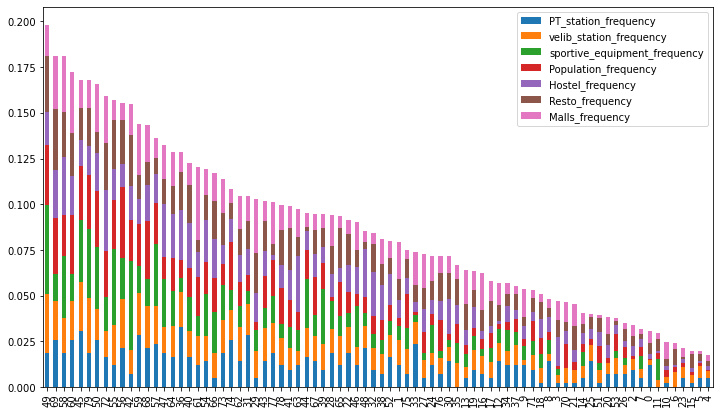

In [43]:
df_frequencies.iloc[:,2:9].plot(kind='bar', stacked=True, figsize=(12,7)) 

In [44]:
paris_map_score= folium.Map( location=[48.866667, 2.333333], zoom_start=12.5)
    
style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
}
    
quartier_paris = r'quartier_paris.geojson'


paris_map_score.choropleth(
    geo_data=quartier_paris,
    data=df_frequencies,
    columns=['NBH_Num','Total'],
    key_on='properties.c_qu',
    fill_color='YlOrRd',
    legend_name = 'Paris Malls/Shops/Services per Borough')

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(paris_map_score)


paris_map_score

C:\Users\jerem\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Because we want to maximize each features, this map give us an idea of which borough got the best potential score. However, it don't tell us the composition of each features. In example, 'Auteuil' seems to be a good candidate but is it because 30% of the pop lives here or is there any sports centers near ?

#### 2.10.2 Borough compositon Analysis

<AxesSubplot:xlabel='NBH_Num', ylabel='Malls_frequency'>

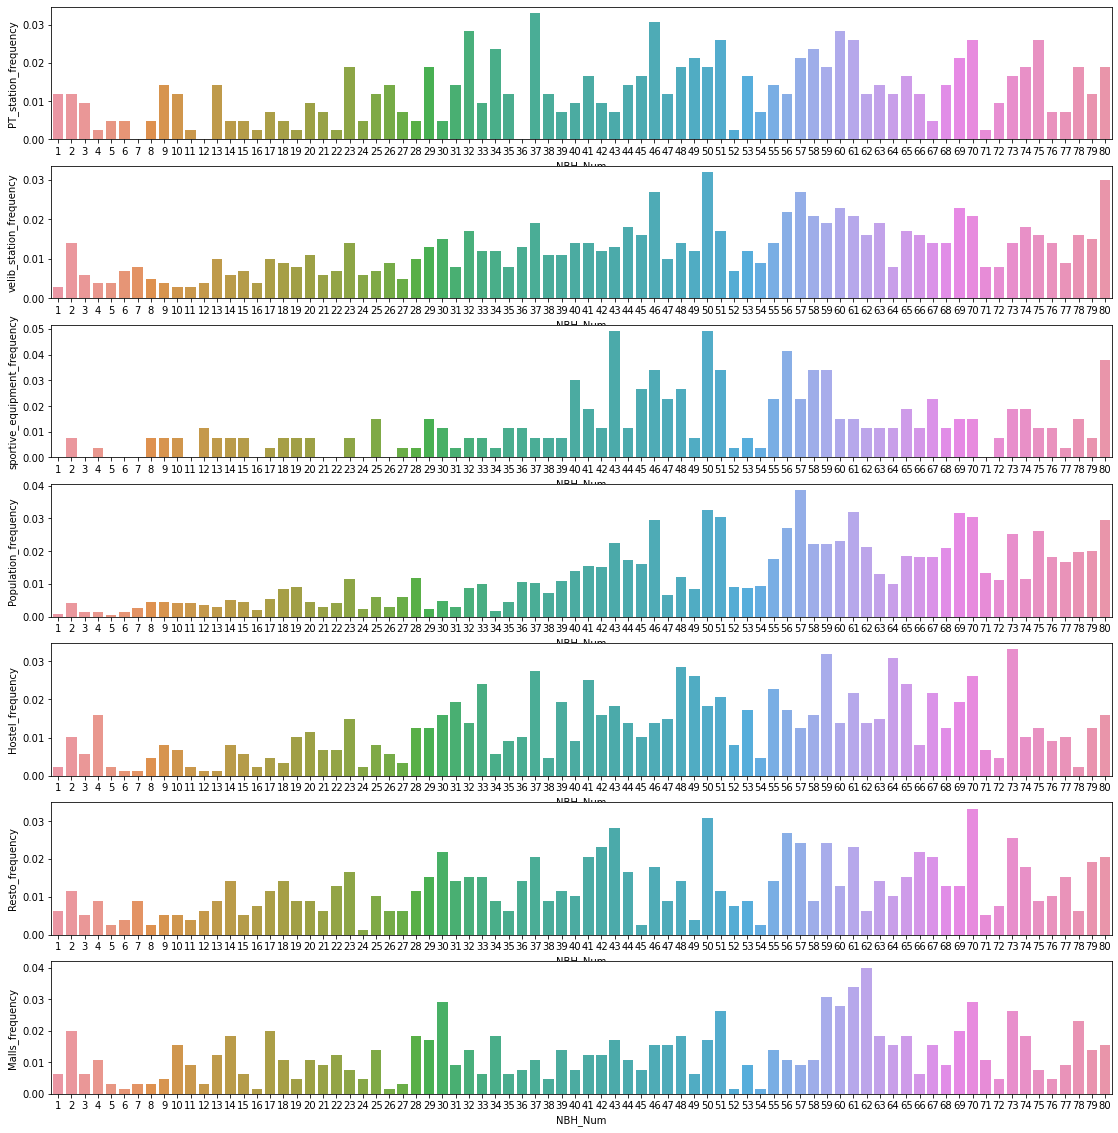

In [45]:
fig, axs = plt.subplots(nrows= 7, ncols=1, figsize=(19,20))
#sns.barplot(x='Cluster Labels', y='Population_in_1999', data=cluster_details_nb, ax=axs[0,0])
'velib_station_frequency','sportive_equipment_frequency','Population_frequency','Hostel_frequency','Resto_frequency','Malls_frequency'
sns.barplot(x='NBH_Num',y='PT_station_frequency',data=df_frequencies, ax=axs[0])
sns.barplot(x='NBH_Num',y='velib_station_frequency',data=df_frequencies, ax=axs[1])
sns.barplot(x='NBH_Num',y='sportive_equipment_frequency',data=df_frequencies, ax=axs[2])
sns.barplot(x='NBH_Num',y='Population_frequency',data=df_frequencies, ax=axs[3])
sns.barplot(x='NBH_Num',y='Hostel_frequency',data=df_frequencies, ax=axs[4])
sns.barplot(x='NBH_Num',y='Resto_frequency',data=df_frequencies, ax=axs[5])
sns.barplot(x='NBH_Num',y='Malls_frequency',data=df_frequencies, ax=axs[6])

Some Boroughs seems to be good candidates for implenting a Co-Working office like the 50, 80, 70,46 but we would like the clusterise them in order to know their similiraties which we are not able to do by now.

### 3 Model selection and details

#### 3.1 Model : kMEANS

KMean is an unsuppervised iterative algorithm which randomly defin a centroid and measure the distance between every points and it.
The distance between all point and their centroïd represent the model's accuracy. (Because we want to minimize it by calculating the Sum Squarred Error).
Also, we want to clearly differenciate each clusters, so the distance between should be maximized. (Silhouette score)
Thus, K means try to minimize the intra cluster distances and maximize the inter-cluster distance.
Because kMEANS is an iterative algorithm, we need to define the best k iteratively first.
Also, our features are very differents so we will standadize its data in order to avoid one feature overtake others. 


#### 3.2 kMEANS : Find the best k (Sum of squared error + silhouette test)

So, how to find out the best k ?
There is two main scorer to evaluate a kMEAN model accuracy : 
- Sum of Squared Error ( The sum of the distance between each points and their centroïd), it has to be minimized.
- Silhouette : It represent the distance between each clusters, it has to be maximized.

In [46]:
Features = df_nbh_finished[['NB of PT station','NB of velib station','NB of sportive equipment','Population_in_1999','NB of hostels','NB of resto','NB of malls']]
Features.head()

NB of PT station  NB of velib station  NB of sportive equipment  \
0               5.0                    3                       0.0   
1               5.0                   14                       2.0   
2               4.0                    6                       0.0   
3               1.0                    4                       1.0   
4               2.0                    4                       0.0   

   Population_in_1999  NB of hostels  NB of resto  NB of malls  
0                1672              2            5            4  
1                8984              9            9           13  
2                3195              5            4            4  
3                3044             14            7            7  
4                1345              2            2            2

In [47]:
from sklearn.preprocessing import StandardScaler
#it's important to standardize data when their scales are very differents (popmax = 2M+ / Soprts Centers max = 264)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Features)
Features_scaled = pd.DataFrame(scaled_data)
Features_scaled.head()

0         1         2         3         4         5         6
0 -0.089803 -1.492265 -1.097189 -1.238312 -1.267656 -0.855631 -0.781868
1 -0.089803  0.228827 -0.434735 -0.874693 -0.276193 -0.136991  0.924025
2 -0.389145 -1.022876 -1.097189 -1.162575 -0.842743 -1.035291 -0.781868
3 -1.287171 -1.335802 -0.765962 -1.170084  0.431994 -0.496311 -0.213237
4 -0.987829 -1.335802 -1.097189 -1.254574 -1.267656 -1.394611 -1.160955

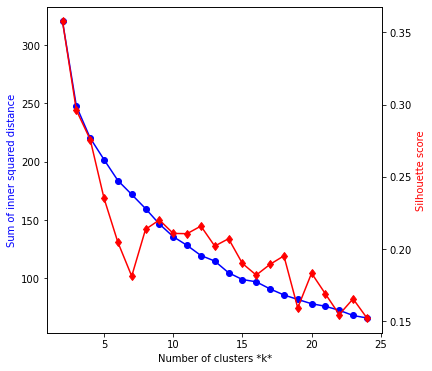

In [48]:
# Choosing the best k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


sse = []
sil = []
list_k = [i for i in range(2,25)]

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(Features_scaled)
    sse.append(km.inertia_)
    sil.append(silhouette_score(Features_scaled, km.labels_))

fig, ax1 = plt.subplots(figsize=(6, 6))

ax2 = ax1.twinx()
ax1.plot(list_k, sse, 'bo-')
ax2.plot(list_k, sil, 'rd-')

ax1.set_xlabel(r'Number of clusters *k*')
ax1.set_ylabel('Sum of inner squared distance', color='b')
ax2.set_ylabel('Silhouette score', color='r')

plt.show()

So the best k is 17 because it's the point where the SSE is minimized for a maximized Silhouette Score.

#### 3.3 Model selection kMEANS with k=17

In [49]:
# set number of clusters
kclusters = 17

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Features_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 0,  3,  0, 15,  0,  0,  0,  0, 14, 14])

## IV - RESULTS

### 1. MAP of each clusters

In [50]:
df_nbh_cluster = df_nbh_finished

In [51]:
cluster = pd.DataFrame({'Cluster Labels':kmeans.labels_})
cluster.head()

Cluster Labels
0               0
1               3
2               0
3              15
4               0

In [52]:
df_nbh_cluster = df_nbh_cluster.join(cluster,how='outer')
df_nbh_cluster.head(2)

NBH_Num    NBH_AREA_m2                   NBH_Name  Arrondissement  \
0        1  869000.664564  Saint-Germain-l'Auxerrois               1   
1        2  412458.496330                     Halles               1   

                                            geometry  NBH_Latitude  \
0  POLYGON ((2.34459 48.85405, 2.34459 48.85405, ...     48.860650   
1  POLYGON ((2.34937 48.86058, 2.34822 48.85852, ...     48.862289   

   NBH_Longitude  NB of PT station  PT_station_frequency  NB of velib station  \
0       2.334910               5.0              0.011792                    3   
1       2.344899               5.0              0.011792                   14   

   velib_station_frequency  NB of sportive equipment  \
0                 0.002991                       0.0   
1                 0.013958                       2.0   

   sportive_equipment_frequency  Population_in_1999  Population_frequency  \
0                      0.000000                1672              0.000787   
1                      0.007547                8984              0.004226   

   NB of hostels  Hostel_frequency  NB of resto  Resto_frequency  NB of malls  \
0              2          0.002283            5         0.006402            4   
1              9          0.010274            9         0.011524           13   

   Malls_frequency  Cluster Labels  
0         0.006154               0  
1         0.020000               3

In [53]:
map_clusters = folium.Map(location=[48.866667, 2.333333], zoom_start=12.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_nbh_cluster['NBH_Latitude'], df_nbh_cluster['NBH_Longitude'], df_nbh_cluster['NBH_Name'], df_nbh_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### 2. Clusters analysis

Now we have an idea of the clusters' position in Paris, but which is the best one to implement our Co-working office ?
We want to choose the one which maximize every features.
So we will calculate the average of each features by borough.

In [54]:
cluster_details_nb = df_nbh_cluster[['Cluster Labels','NB of PT station','NB of velib station','NB of sportive equipment','Population_in_1999','NB of hostels','NB of resto','NB of malls']]

In [55]:
# Calcul of the average by cluster
cluster_details_nb = cluster_details_nb.groupby(['Cluster Labels']).mean()
cluster_details_nb.reset_index('Cluster Labels',inplace=True)

<AxesSubplot:xlabel='Cluster Labels', ylabel='NB of malls'>

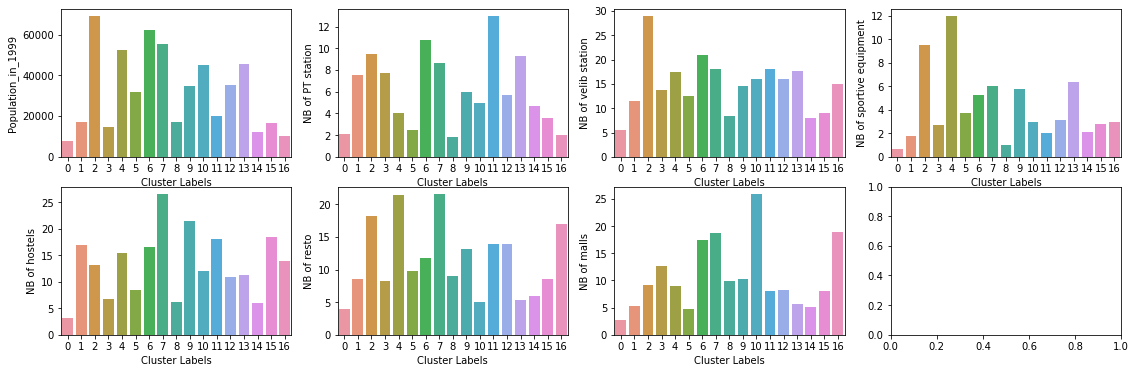

In [56]:
fig, axs = plt.subplots(nrows= 2, ncols=4, figsize=(19,6))
sns.barplot(x='Cluster Labels', y='Population_in_1999', data=cluster_details_nb, ax=axs[0,0])
sns.barplot(x='Cluster Labels', y='NB of PT station', data=cluster_details_nb, ax=axs[0,1])
sns.barplot(x='Cluster Labels', y='NB of velib station', data=cluster_details_nb, ax=axs[0,2])
sns.barplot(x='Cluster Labels', y='NB of sportive equipment', data=cluster_details_nb, ax=axs[0,3])
sns.barplot(x='Cluster Labels', y='NB of hostels', data=cluster_details_nb, ax=axs[1,0])
sns.barplot(x='Cluster Labels', y='NB of resto', data=cluster_details_nb, ax=axs[1,1])
sns.barplot(x='Cluster Labels', y='NB of malls', data=cluster_details_nb, ax=axs[1,2])

### 3. Select the best cluster

Following those charts, the cluster 2 is the best one to implement our co-working office because it maximized every features. Followed by the 7 and 6 one.

In [57]:
df_cluster2 = df_nbh_cluster[df_nbh_cluster['Cluster Labels']==2]

In [58]:
map_cluster_2 = folium.Map(location=[48.866667, 2.333333], zoom_start=12.5)

style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
}
    

folium.GeoJson(
    quartier_paris,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['l_qu','c_qu','c_ar'],localize=True,aliases=['Borough Name','Borough Number','Arrondissement'])
).add_to(map_cluster_2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster2['NBH_Latitude'], df_cluster2['NBH_Longitude'], df_cluster2['NBH_Name'], df_cluster2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color='blue',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_cluster_2)
       
map_cluster_2

The best borough to set our co-working office are : Picpus (46), Gare(50), Saint-Lambert(57), Charonne(80)

## V - Discussion and conclusion

In this study, we have merged a lot of information to describe a Borough : Public Transport Station, Velib Station, Popuplation, Nb of Hostels, Restaurant and Malls.
Because of the hudge Number of Borough in Paris, it wasn't easy at the first look to define where is the best place. Even if few Borough seemed to be good candidates.
Next we have set up a kMEANS model to clusterize each Borough and we have qualified them. To do it, we have calculated the average of each features by cluster and dertimined which one had the best score.

That how we clearly defined Cluster 2 as the best one to set our co-working office. It is composed by the following borough : Picpus (46), Gare(50), Saint-Lambery(57), Charonne(80)

Also, it wasn't easy to clean each Data Set because they came from very differents sources (wikipedia, French Open Data Project, Foursquare), but it was challenging and we if we could have more data on the Foursquare result we could have got a more precise model. Indeed, we have the number of hostel, restaurant, services but we don't know their notation. If we did we could have determined the more 'qualitative' borough.

To conclude, I have checked the last news on the cluster 2 borough and for example, Charonne has recently been selected to develop the new Green Borough in Paris. Saint-Lambert is a very cultural borough... So our model is precise and consistent.